## Libraries

In [1]:
 #! pip install onnxruntime

In [2]:
#print(torch.__version__)

In [3]:
import numpy as np
import torch
import pandas as pd
import sklearn
import random #for splitting

#for building the NN
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [4]:
#for the correlation matrix
from mlxtend.plotting import heatmap
#to show the correlation matrix
import matplotlib.pyplot as plt
#for splitting training and testing data
from sklearn.model_selection import train_test_split
#for data loader
from torch.utils.data import TensorDataset, DataLoader
#coeficient of determination only allows numpy as an input
from sklearn.metrics import r2_score

import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor


In [49]:
import onnxruntime as rt
from skl2onnx.common.data_types import FloatTensorType
import onnxmltools 

## Parameters

In [6]:
batch_size=16
learning_rate=0.001 #this can be changed to make the model better 
N_Epochs=100
epsilon= 0.0001

## Read Data

In [7]:
#create pandas dataset with raw csv data
path_data='C:/Users/danda/Desktop/ITS 520/PyTorch-main/basics/data/data/winequality-white.csv'
WINE_raw_data = pd.read_csv(path_data, delimiter=';')


In [8]:
WINE_raw_data

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.00100,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.99400,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.99510,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.99560,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.99560,3.19,0.40,9.9,6
...,...,...,...,...,...,...,...,...,...,...,...,...
4893,6.2,0.21,0.29,1.6,0.039,24.0,92.0,0.99114,3.27,0.50,11.2,6
4894,6.6,0.32,0.36,8.0,0.047,57.0,168.0,0.99490,3.15,0.46,9.6,5
4895,6.5,0.24,0.19,1.2,0.041,30.0,111.0,0.99254,2.99,0.46,9.4,6
4896,5.5,0.29,0.30,1.1,0.022,20.0,110.0,0.98869,3.34,0.38,12.8,7


In [9]:
#set the column names into a list of headers
headers_list=WINE_raw_data.columns.values.tolist()
headers_list

['fixed acidity',
 'volatile acidity',
 'citric acid',
 'residual sugar',
 'chlorides',
 'free sulfur dioxide',
 'total sulfur dioxide',
 'density',
 'pH',
 'sulphates',
 'alcohol',
 'quality']

In [10]:
headers_list2=['density',
 'pH',
 'sulphates',
 'alcohol',
 'quality']

## Data Analysis
* Correlation Matrix

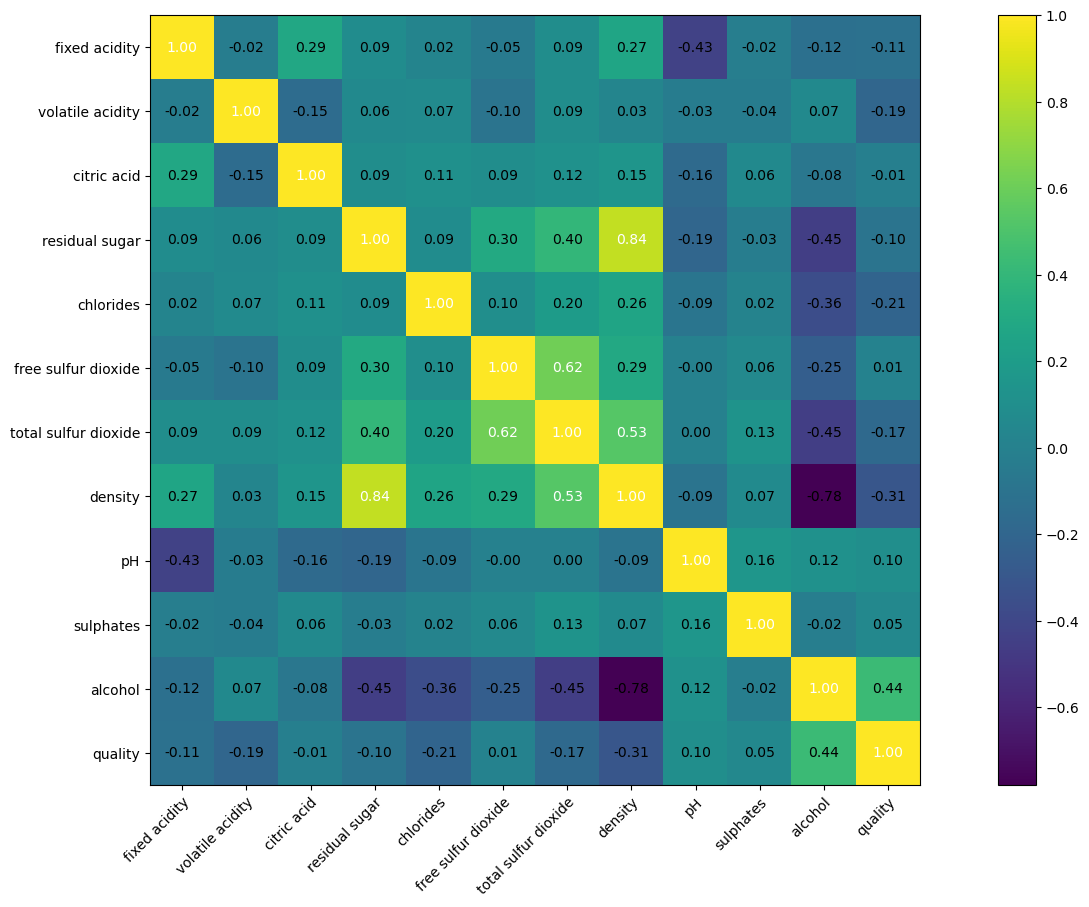

In [11]:
#creating the correlation matrix with the wine data
cm=np.corrcoef(WINE_raw_data[headers_list].values.T)
#creats the heatmap
hm=heatmap(cm, row_names=headers_list, column_names=headers_list, figsize=(20,10))
#shows the plot
plt.show()

## Process Data

In [12]:
## Convert Pandas data to Numpy
WINE_raw_data_NP=WINE_raw_data.to_numpy()

In [13]:
WINE_raw_data_NP.shape


(4898, 12)

In [14]:
#seperate the X (input) and y (output) data 
X=WINE_raw_data_NP[:, 0:-1] #could be [:, [1, 2, 3]]#if you want the a specific three rows as inputs
y=WINE_raw_data_NP[:, -1:] #could be [:, [-2, -1]] if you want the last two rows as outputs, add colon at end to show 1
print(X.shape)
print(y.shape)

(4898, 11)
(4898, 1)


In [15]:
random_seed= int(random.random()*100)  #sets the seed to change everytime you run

In [16]:
#split into training and testing data
X_train, X_test, y_train, y_test= train_test_split(X, y, test_size=0.2, random_state=random_seed)#test size is percentage

In [17]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(3918, 11)
(980, 11)
(3918, 1)
(980, 1)


## Torch float 64 fix

In [18]:
#torch does not like some things, so you have to fix
#doesn't like float64, so set to float 32
X_train=X_train.astype(np.float32)
X_test=X_test.astype(np.float32)
y_train=y_train.astype(np.float32)
y_test=y_test.astype(np.float32)

In [19]:
#turn numpy data into torch data
X_train_tr=torch.from_numpy(X_train)
X_test_tr=torch.from_numpy(X_test)
y_train_tr=torch.from_numpy(y_train)
y_test_tr=torch.from_numpy(y_test)

## Normalization
* Normalization 
* Standardization (prefered implementation)

In [20]:
x_means= X_train_tr.mean(0, keepdim=True)
x_deviations = X_train_tr.std(0, keepdim=True)+ epsilon

In [21]:
x_means

tensor([[6.8600e+00, 2.7847e-01, 3.3560e-01, 6.4160e+00, 4.5405e-02, 3.5320e+01,
         1.3858e+02, 9.9402e-01, 3.1877e+00, 4.9033e-01, 1.0526e+01]])

In [22]:
x_deviations

tensor([[8.3679e-01, 1.0024e-01, 1.2114e-01, 5.0295e+00, 2.1257e-02, 1.6911e+01,
         4.2416e+01, 3.0382e-03, 1.4990e-01, 1.1492e-01, 1.2386e+00]])

## Create the DataLoader

In [23]:
#creating the dataloader training data
train_ds=TensorDataset(X_train_tr, y_train_tr)

In [24]:
#creating the data loader 
train_dl=DataLoader(train_ds, batch_size, shuffle=True)

In [25]:
train_dl

## Neural Network Architectures

In [26]:
## Linear Regression
#this is not a neural network, it juest helps explain the layers
#this is the inference function
class LinRegNet(nn.Module):
    # initialize the class
    def __init__(self, x_means, x_deviations):
        super().__init__() #initilizes the functions of the class being inherited
        self.x_means=x_means
        self.x_deviations=x_deviations
        #self.linear1=nn.Linear(#feature value of each vector( 11), #num output columns (1) ) #defining the architecture
        self.linear1=nn.Linear(11, 1)
    #perform inference
    def forward(self, x):
        #standardization equation
        x=(x - self.x_means)/self.x_deviations
        y_pred=self.linear1(x)
        return y_pred

In [27]:
##MLP stands for multilayer perceptor 
#first official neural network
#this is similar to linear regression but it has a hidden layer inbetween the input and output
#usually the size of the hidden layer is smaller than the input but bigger than output layer
#in this instance out input is 11, output is 1, and hidden layer is 8
#all 11 inputs are put into an activation function 8 times (as many times as the size of hidden layer), the hidden layer 
#values are then processed into one output into the true output layer
#we will use a sigmoid value (a value between 0 and 1) for the hidden layer
#linear returns a straight line, and an MLP can return more than just a straight line
class MLP_Net(nn.Module):
    # initialize the class
    def __init__(self, x_means, x_deviations):
        super().__init__() #initilizes the functions of the class being inherited
        self.x_means=x_means
        self.x_deviations=x_deviations
        #self.linear1=nn.Linear(#feature value of each vector( 11), #num hidden layer columns (1) ) #defining the architecture
        self.linear1=nn.Linear(11, 8)
        self.act1=nn.Sigmoid() #the activation function between the layers
        self.linear2=nn.Linear(8, 1)
        #dropout can be used to make a model better
        self.dropout=nn.Dropout(0.25)#drops out 25% of all connections so 6 paths instead of 8 and the connection that drops changes every iteration
    #perform inference
    def forward(self, x):
        #standardization equation
        x=(x - self.x_means)/self.x_deviations
        #pass the x data into the first layer, the activation layer, and then the third layer and then output
        x=self.linear1(x)
        x=self.act1(x)
        x=self.dropout(x)
        y_pred=self.linear2(x)
        return y_pred

In [28]:
#Deep Learning Network
#can have between 2-10 layers
#Geoffrey Hinton coined the term deep learning

#we will do 2 hidden layers for this
class DL_Net(nn.Module):
    # initialize the class
    def __init__(self, x_means, x_deviations):
        super().__init__() #initilizes the functions of the class being inherited
        self.x_means=x_means
        self.x_deviations=x_deviations
        #self.linear1=nn.Linear(#feature value of each vector( 11), #num hidden layer columns (1) ) #defining the architecture
        self.linear1=nn.Linear(11, 10)
        self.act1=nn.ReLU() #the activation function between the layers
        self.linear2=nn.Linear(10, 6)
        self.act2=nn.ReLU()
        self.linear3=nn.Linear(6, 1)
        self.dropout=nn.Dropout(0.25)#drops out 25% of all connections so 6 paths instead of 8 and the connection that drops changes every
        #dropout can be used to make a model better
        #self.dropout=nn.Dropout(0.25)#drops out 25% of all connections so 6 paths instead of 8 and the connection that drops changes every iteration
    #perform inference
    def forward(self, x):
        #standardization equation
        x=(x - self.x_means)/self.x_deviations
        #pass the x data into the first layer, the activation layer, and then the third layer and then output
        x=self.linear1(x)
        x=self.act1(x)
        x=self.linear2(x)
        x=self.act2(x)
        x=self.dropout(x)
        y_pred=self.linear3(x)
        return y_pred

In [29]:
#Linear + Non-linear net
#f1+f2 a linear model + a non-linear model and predict with it
#the second function can be an MLP or DL
##Homework assignment to mess around with this model to make the best model possible
class LinPlusNonLin_Net(nn.Module):
    # initialize the class
    def __init__(self, x_means, x_deviations):
        super().__init__() #initilizes the functions of the class being inherited
        self.x_means=x_means
        self.x_deviations=x_deviations
        ##F1 linear network
        self.f1_linear1=nn.Linear(11,1)
        ##F2
        self.f2_linear1=nn.Linear(11, 14)
        self.f2_act1=nn.ReLU()
        self.f2_linear2=nn.Linear(14, 8)
        self.f2_act2=nn.Sigmoid()
        self.f2_linear3=nn.Linear(8, 5)
        self.f2_act3=nn.Sigmoid()
        self.f2_linear4=nn.Linear(5, 1)
    def forward(self, x):
        #standardization equation
        x=(x - self.x_means)/self.x_deviations
        #pass the x data into the first layer, the activation layer, and then the third layer and then output
        ##F1
        f1=self.f1_linear1(x)
        #F2
        f2=self.f2_linear1(x)
        f2=self.f2_act1(f2)
        f2=self.f2_linear2(f2)
        f2=self.f2_act2(f2)
        f2=self.f2_linear3(f2)
        f2=self.f2_act3(f2)
        f2=self.f2_linear4(f2)
        y_pred=f1+f2
        return y_pred

## Training Loop

In [30]:
def training_loop(N_Epochs, model, loss_fn, opt):
    for epoch in range(N_Epochs):
        for xb, yb in train_dl:
            y_pred=model(xb) #invoke inferefence function, xb is x bias
            loss = loss_fn(y_pred, yb)#comparing the predicted to the real
            #this is creating a computations graph in memory that is very connected
            opt.zero_grad() #you have to zero out the weights because they accumulate for some reason without this
            loss.backward()#this is the node that conencts everything in the computational graph
            opt.step() #updates the weights, optimizer defines the step size, back propogation
        #print the loss every 200 iterations
        if epoch % 20 == 0:
            print(epoch, "loss=", loss)
            
        

In [31]:

#model=LinRegNet(x_means, x_deviations) #inference ?

#model=MLP_Net(x_means, x_deviations)
model=LinPlusNonLin_Net(x_means, x_deviations)
opt = torch.optim.Adam(model.parameters(), lr=learning_rate) #optimizer
# we want to minimize the loss value to make it better 
loss_fn = F.mse_loss #loss function

training_loop(N_Epochs, model, loss_fn, opt)

0 loss= tensor(13.9544, grad_fn=<MseLossBackward0>)
20 loss= tensor(0.4577, grad_fn=<MseLossBackward0>)
40 loss= tensor(0.7501, grad_fn=<MseLossBackward0>)
60 loss= tensor(0.7279, grad_fn=<MseLossBackward0>)
80 loss= tensor(0.4274, grad_fn=<MseLossBackward0>)


## Build a Model

## Evaluate Model

In [32]:
#now that the model has been trained we need to test the model using the test set the evaluate how good the model is
y_pred_test=model(X_test_tr)

In [33]:
y_pred_test.shape

torch.Size([980, 1])

In [34]:
#r2 is used to determine how good the model is
#r2 score require numpy, the tensor need to be detached from the graph before using and turned into numpy
#you want to maximize the r2, the larger the number the better it is
pytorch_R2=r2_score(y_test_tr.numpy(), y_pred_test.detach().numpy())
print("Testing R**2: ", pytorch_R2)

#standardization in this specific instance made the model better, and it usually will make this metric better
#the higher this is, the better the prediction is, this is a way of comparing models and seeing which one will give you the best
##results. This goes up to 1 and the higher the number is the better
#Calix thinks that because some of the data is integers than this might make the model not as good, that is one thing we could change to maybe make it better

Testing R**2:  0.36054570643326633


In [35]:
#print(y_pred_test.shape)
#print(y_test_tr.shape)

In [36]:
list_preds=[]
list_reals=[]
for i in range(len(X_test_tr)):
    #print("*********************************************************")
    #print("pred, real")
    np_real=y_test_tr[i].detach().numpy()
    np_pred=y_pred_test[i].detach().numpy()
    #print(np_pred[0], np_real[0])
    list_preds.append(np_pred[0])
    list_reals.append(np_real[0])

## Deploy Pytorch Model

In [37]:
#set modelt o eval mode so it is no longer training
model.eval()
dummy_input=torch.randn(1, 11) #collect 11 values from 11 text boxes (row vector)
#create values to reference when pulling data from onnx
input_names=["input1"]
output_names=["output1"]

torch.onnx.export(
    model, #pass model
    dummy_input, #input, it knows how it will output
    "DLnet_WineData.onnx", #name of the file
    verbose=False,
    input_names=input_names,
    output_names=output_names
)

============== Diagnostic Run torch.onnx.export version 2.0.1+cpu ==============
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================



## XGBoost

In [38]:
print("Random Seed: ", random_seed)

Random Seed:  15


In [39]:
regressor = xgb.XGBRegressor(
    eta=0.03, #learning rate
    n_estimators=1000,
    reg_lambda=0, #goes big bad
    gamma=0, #changing this is big bad
    max_depth=6 #default
)

In [40]:
regressor.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eta=0.03, eval_metric=None,
             feature_types=None, gamma=0, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=1000,
             n_jobs=None, num_parallel_tree=None, ...)

In [41]:
y_pred=regressor.predict(X_test)

In [42]:
xgboost_R2=r2_score(y_test, y_pred)

### Random forest

In [43]:
random_forest = RandomForestRegressor(
    n_estimators=300, #sweet
    criterion="friedman_mse", #made no difference
    min_samples_split=2, #default
    random_state = random_seed, #sweet
    warm_start=True, #reuses last runs data + adds new, no change
    max_depth = 25
)
random_forest.fit(X_train, y_train)
y_pred = random_forest.predict(X_test)

C:\Users\danda\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


In [44]:
print("Random Seed Data set #: ", random_seed)
print("Testing R**2: ", pytorch_R2)
print("XGBoost R**2: ", xgboost_R2)
print("Random Forest R**2: ", r2_score(y_test, y_pred))

Random Seed Data set #:  15
Testing R**2:  0.36054570643326633
XGBoost R**2:  0.512160818959673
Random Forest R**2:  0.5366285612064947


## Visualize test Predictions

In [45]:
#visualize the difference between every prediction versus the real result
def plot_preds_vs_reals(list_preds, list_reals):
    plt.figure(figsize=(13, 4))
    plt.plot(list_reals, label='real', color='r')
    plt.plot(list_preds, label='pred')
    plt.show()

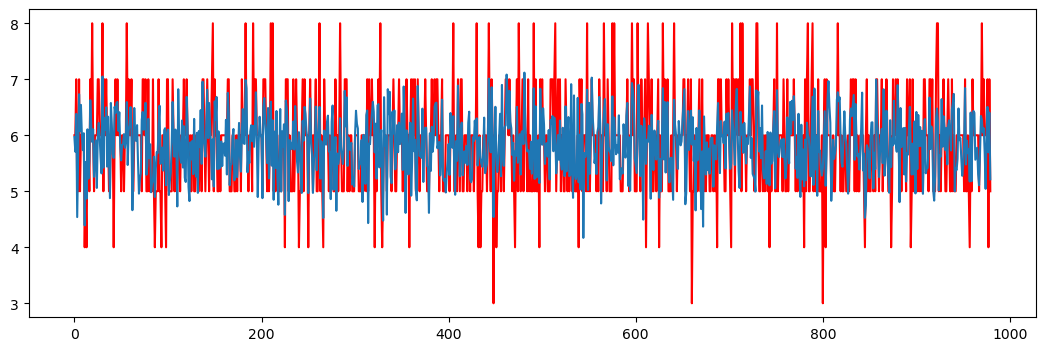

In [46]:
plot_preds_vs_reals(list_preds, list_reals)
#in a perfect world you would only see one color, or at least there would not be a lot of difference between the two colors

## Deploy Model
* ONNX and Github

In [47]:
model.eval()
dummy_input=torch.randn(1, 11)
input_names=['input1']
output_names=['output1']
torch.onnx.export(

    model,
    dummy_input,
    "DLnet_WineData.onnx",
    verbose=False,
    input_names=input_names,
    output_names=output_names
)

============== Diagnostic Run torch.onnx.export version 2.0.1+cpu ==============
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================



## ONNX Runtime

In [48]:
initial_types=[(
    'float_input',
    FloatTensorType([None, 11]),
)]

In [51]:
onnx_model=onnxmltools.convert_xgboost(regressor, initial_types=initial_types)
onnxmltools.utils.save_model(onnx_model, 'XGBoost_WineQuality_ort.onnx')

In [52]:
sess=rt.InferenceSession('XGBoost_WineQuality_ort.onnx')

In [56]:
input_name=sess.get_inputs()[0].name
label_name=sess.get_outputs()[0].name

In [58]:
print(input_name)
print(label_name)

float_input
variable


In [59]:
pred_ort=sess.run([label_name], {input_name: X_test.astype(np.float32)})

In [61]:
pred_ort[0]

array([[ 7.16938019e-01],
       [ 6.39579535e-01],
       [ 1.44478083e+00],
       [-6.90139651e-01],
       [-2.00067759e-01],
       [ 9.65045333e-01],
       [-3.61316204e-01],
       [ 8.12677860e-01],
       [ 3.59128714e-01],
       [ 4.59255278e-01],
       [ 9.31163967e-01],
       [-1.58784652e+00],
       [-1.26631856e-01],
       [-1.04405081e+00],
       [ 6.41837358e-01],
       [ 7.55301416e-02],
       [ 2.56844044e-01],
       [ 1.53000784e+00],
       [ 5.63116431e-01],
       [ 2.25206792e-01],
       [ 6.53866708e-01],
       [-3.62460911e-01],
       [-7.82979131e-02],
       [ 5.68904042e-01],
       [ 3.74339074e-01],
       [ 1.37523508e+00],
       [ 1.03441310e+00],
       [ 3.72710228e-02],
       [ 5.75127184e-01],
       [ 3.28813881e-01],
       [ 1.55335391e+00],
       [ 3.01018775e-01],
       [ 1.29635429e+00],
       [ 9.69652057e-01],
       [ 6.30308986e-01],
       [ 4.40871656e-01],
       [ 6.57786846e-01],
       [-3.85518551e-01],
       [-6.2